# Emotion transitions study: Emotion responses cluster analysis
Rubia Guerra, Mar 24th 2022

### Imports and data split

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy import signal
from statsmodels.tsa import stattools

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from tqdm import tqdm

plt.style.use("seaborn")

%matplotlib inline

In [83]:
def load_and_split_dataset(data_dir = 'data/p*', split_size=100, random_seed=128, split_ratio = .7, subject_choice_seed=128):
    subject_data_files = glob.glob(os.path.join(data_dir, 'joystick.mat'))
    subject_data_files.sort()
    num_subjects = int(len(subject_data_files) * split_ratio)
    
    # group data, pick subjects randomly
    np.random.seed(subject_choice_seed)
    all_subjects = np.random.choice(subject_data_files, size=num_subjects, replace=False)
    subjects = re.findall('p\d+', ''.join(all_subjects))
    print(f"Training set participants: {subjects}")
    
    train = []
    test = []
    for subject_filename in subject_data_files:
        mat_contents = sio.loadmat(subject_filename)
        df = pd.DataFrame(mat_contents['var'], columns=['Timestamp', 'Feeltrace'])
        
        if subject_filename in all_subjects:
            train.append(df)
        else:
            test.append(df)
    
    return train, test


In [84]:
[train, test] = load_and_split_dataset()

Training set participants: ['p23', 'p22', 'p2', 'p10', 'p5', 'p8', 'p7', 'p12', 'p17', 'p6', 'p4']


### Defining emotion dynamics features
Refer to _Houben M, Van Den Noortgate W, Kuppens P. The relation between short-term emotion dynamics and psychological well-being: A meta-analysis. Psychological bulletin. 2015 Jul;141(4):901._

In [85]:
class EmotionDynamics:
    def __init__(self, Fs=30, interval=300, verbose=False):
        self.lag = Fs*interval
        self.verbose=verbose
        
    def emotion_variability(self, X: np.array):
        return np.std(X)

    def emotion_instability(self, X: np.array):
        return np.sum((X[1:] - X[:-1])**2)/(len(X)-1) # MSSD

    def emotional_inertia(self, X, lag=None):
        if lag is None:
            lag = self.lag
#         if !lag.isinstance(int):
#             lag = int(lag)
        return stattools.acf(X, nlags=lag)[lag] # Autocorrelation

    def emotional_range(self, X: np.array):
        return np.abs(min(X)-max(X))
    
    def get_parameters(self, X: np.array):
        parameters = {'Inertia':'', 'Instability':'', 'Range':'', 'Variability':''}
        parameters['Inertia'] = self.emotional_inertia(X)
        parameters['Instability'] = self.emotion_instability(X)
        parameters['Range'] = self.emotional_range(X)
        parameters['Variability'] = self.emotion_variability(X)
        if self.verbose:
            print(parameters)
        return parameters

In [86]:
ED = EmotionDynamics(verbose=False)

In [87]:
ED.get_parameters(train[1]['Feeltrace'])

{'Inertia': -0.03152622069122684,
 'Instability': 0.0,
 'Range': 209.0,
 'Variability': 49.07772720654508}

In [88]:
training_data = []
for subject in train:
    feeltrace = np.array(subject['Feeltrace'])
    training_data.append(ED.get_parameters(feeltrace))

In [89]:
test_data = []
for subject in test:
    feeltrace = np.array(subject['Feeltrace'])
    test_data.append(ED.get_parameters(feeltrace))

In [90]:
X_train = pd.DataFrame(training_data)
X_test = pd.DataFrame(test_data)
X_train

,Inertia,Instability,Range,Variability
0,0.012713,0.593234,185.0,32.349176
1,-0.031526,1.278632,209.0,49.077727
2,-0.138167,0.761333,225.5,42.022961
3,-0.084194,0.714600,213.0,39.557379
4,-0.026253,1.056519,184.0,38.449633
5,0.010896,0.808034,153.0,29.005620
6,-0.035573,0.985158,223.0,48.939746
7,0.040190,0.952268,194.0,29.056105
8,0.055261,1.015773,184.0,48.688655
9,-0.112607,0.796932,222.0,42.722726


In [91]:
X = X_train.append(X_test).reset_index(drop=True)
X

,Inertia,Instability,Range,Variability
0,0.012713,0.593234,185.0,32.349176
1,-0.031526,1.278632,209.0,49.077727
2,-0.138167,0.761333,225.5,42.022961
3,-0.084194,0.714600,213.0,39.557379
4,-0.026253,1.056519,184.0,38.449633
5,0.010896,0.808034,153.0,29.005620
6,-0.035573,0.985158,223.0,48.939746
7,0.040190,0.952268,194.0,29.056105
8,0.055261,1.015773,184.0,48.688655
9,-0.112607,0.796932,222.0,42.722726


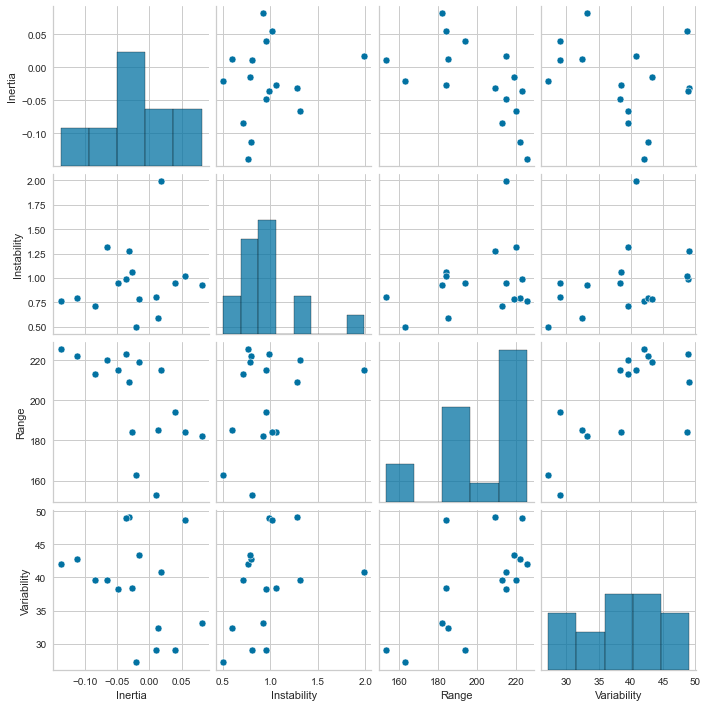

In [92]:
sns.pairplot(X)

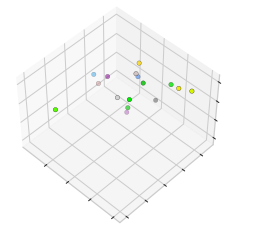

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134, auto_add_to_figure=False)
fig.add_axes(ax)

plt.cla()

ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=X_scaled[:, 3], cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

### Principal Component Analysis

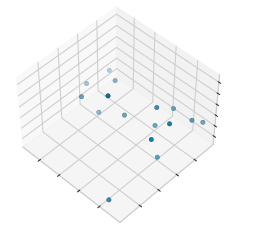

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134, auto_add_to_figure=False)
fig.add_axes(ax)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X_scaled)
X = pca.transform(X_scaled)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

### Gaussian Mixture Model

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [96]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn import metrics

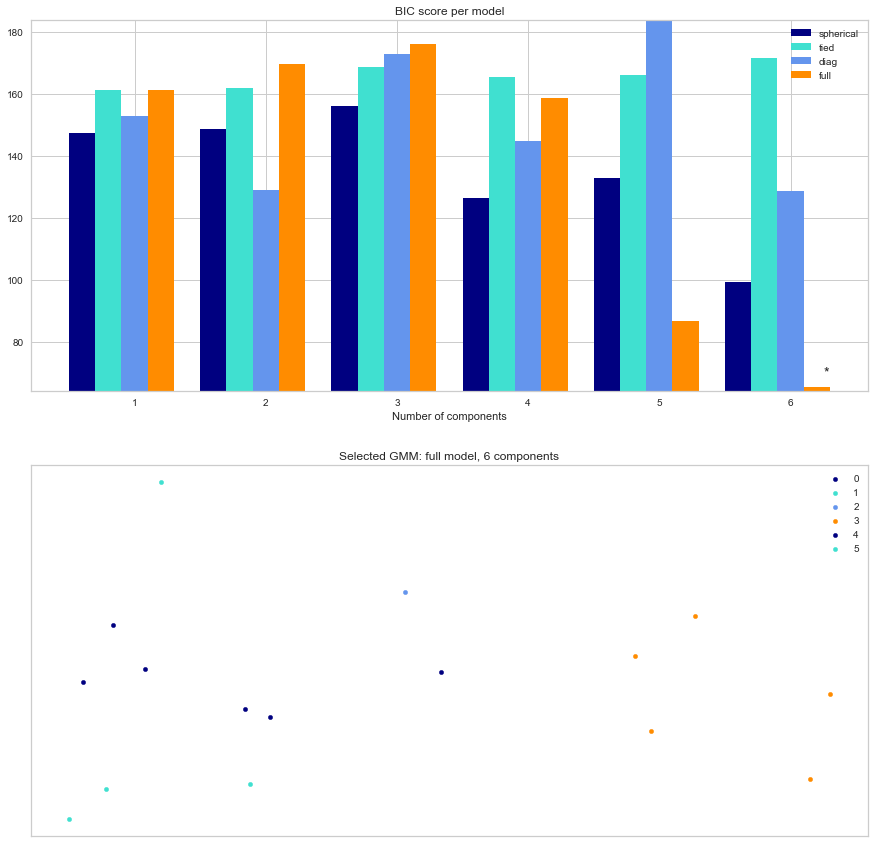

In [99]:
"""
================================
Gaussian Mixture Model Selection
================================

This example shows that model selection can be performed with
Gaussian Mixture Models using information-theoretic criteria (BIC).
Model selection concerns both the covariance type
and the number of components in the model.
In that case, AIC also provides the right result (not shown to save time),
but BIC is better suited if the problem is to identify the right model.
Unlike Bayesian procedures, such inferences are prior-free.

In that case, the model with 2 components and full covariance
(which corresponds to the true generative model) is selected.

"""

import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_scaled)
        bic.append(gmm.bic(X_scaled))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 15))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_scaled)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_scaled[Y_ == i, 0], X_scaled[Y_ == i, 1], 20, color=color)

#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180.0 * angle / np.pi  # convert to degrees
#     v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(0.5)
#     splot.add_artist(ell)

plt.legend(range(len(clf.means_)))
plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
# plt.subplots_adjust(hspace=0.55, bottom=0.02)
plt.show()
